## Importiere `pandas`, `matplotlib`

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
from datetime import datetime as dt
import locale
from scipy.interpolate import interp1d
from configparser import ConfigParser
from functions import *

## Lade die Konfigurationen aus `config.ini`
#### Definiere die Umgebung

In [22]:
config = ConfigParser()
files = config.read('config.ini')

# Wechsel des plt.style per config.ini machbar.
plt.style.use(config.get('theme', 'plt.style'))

# Damit Daten mit den deutschen Begriffen für die Monat generiert werden.
locale = locale.setlocale(locale.LC_TIME, "de_DE")

In [23]:
env = 'test'
database_file = config.get(env, 'database_file')
date_begin = config.get(env, 'date_begin')
date_end = config.get(env, 'date_end')
dpi = config.get(env, 'dpi')

In [24]:
df = pd.read_json(database_file)

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [25]:
df = df.loc[(df['date'] >= date_begin) & (df['date'] <= date_end)]

In [26]:
df['date'] = pd.to_datetime(df['date'], utc=True)

#### Füge ein neues Feature hinzu: Themengebiet

In [27]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topics[topic]['name']

#### Zähle die Artikel pro Themengebiet

In [28]:
df_topic = df.topic.value_counts().reset_index(name="amount")
df_topic['color'] = "#8ecae6" # BLUE
df_topic['edgecolor'] = "#219ebc" # BLUE

## Erstelle das Diagramm

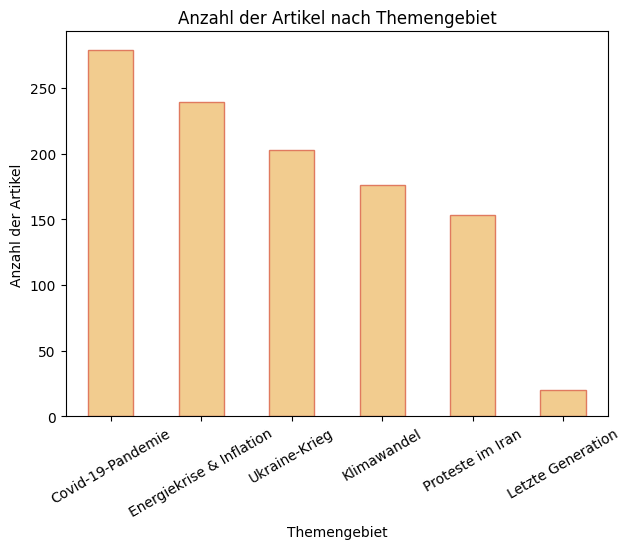

In [29]:
ax = df_topic.plot(kind="bar", x="index", y="amount", ylabel="Anzahl der Artikel", xlabel="Themengebiet", figsize=(7,5), legend=False, rot=30, color="#f2cc8f", edgecolor='#e07a5f', title="Anzahl der Artikel nach Themengebiet")

ax.get_figure().savefig('figures/bar-topic.png', bbox_inches="tight", dpi=float(dpi))

#### Benenne das Feature `index` zu `topic`

In [30]:
df_topic['topic'] = df_topic['index']

#### Mache Abstufungen in den Farbintensitäten, indem Transparenzwerte angehangen werden

In [31]:
# transparent value from 100% - 10% * n; >34%
transparencies = ["FF", "E6", "CC",  "B3", "80",  "66", "4D"]
used = {"topic": -1}

def highlight_color(row):
    used["topic"] += 1
    row.color += transparencies[used['topic']]
    return row
    
df_topic = df_topic.apply(highlight_color, axis=1)

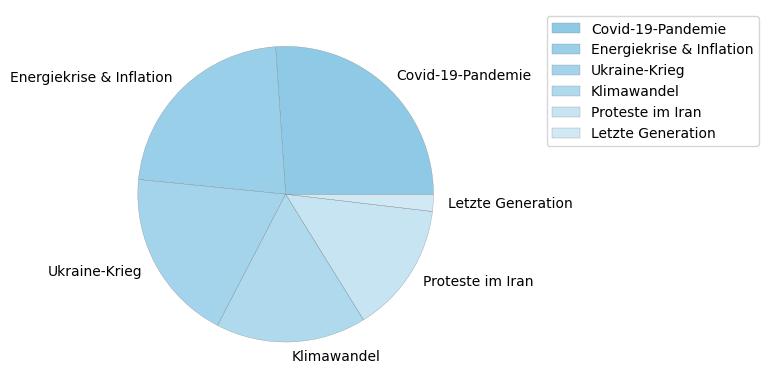

In [32]:
ax = df_topic.plot(kind="pie", y="amount", labels=df_topic.topic, colors=df_topic.color,  wedgeprops={"edgecolor": "grey", 'linewidth': 0.2, 'linestyle': 'solid', 'antialiased': True})

ax.axes.get_yaxis().get_label().set_visible(False)

ax.legend(labels=df_topic.topic, bbox_to_anchor=(1.8, 1.0))

ax.get_figure().savefig('figures/pie-topic.png', bbox_inches="tight", dpi=float(dpi))